<a href="https://colab.research.google.com/github/biboella/COGS108_Repo/blob/main/Data_CheckPoint_COGS108_077.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# COGS 108 - EDA Checkpoint


## Names


*   Connor McManigal
*   Ryan Swartz
*   Matthew Cohen
*   Xuwen Yan(Ella)
*   Egor Pustovalov



# Research Question
Is there an association between an NBA team’s number and rank of injured players to their record from the 2010 season through the 2015 season? Also, can we accurately predict a team’s change in record based on injuries that occur in future seasons?




## Setup
Two files containing the datasets are required for this notebook. The links to them are provided in the data cleaning section. 


In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import datetime

import patsy
import statsmodels.api as sm
import scipy.stats as stats
from scipy.stats import ttest_ind, chisquare, normaltest
from scipy.stats import ks_2samp
from scipy.stats import pearsonr

import patsy
import statsmodels.api as sm
import statsmodels.formula.api as smf

from sklearn.metrics import accuracy_score
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from sklearn.model_selection import train_test_split


from IPython.display import display_html 

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

MessageError: ignored

In [ ]:
#deal with excel datasets
import pip
pip.main(["install", "openpyxl"])


Please see https://github.com/pypa/pip/issues/5599 for advice on fixing the underlying issue.
To avoid this problem you can invoke Python with '-m pip' instead of running pip directly.


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


0

## Data Cleaning
The following section presents information on the data cleaning steps for the two datasets used in this report. 

## First Dataset - Injury Stats
### Link to Dataset: https://www.kaggle.com/datasets/ghopkins/nba-injuries-2010-2018
### No. Observations: 17,408 
This dataset describes the occurance, injury type, player team, and time of injury for NBA players in the 2010 - 2020 years. 

The information present here will be combined with the Historical NBA Performance dataset to match players with their teams for a given year. This will allow us to show how the number of injuries across different players for the same team impacts the team's historical performance. 

In [ ]:
#first dataset - Injury stats
injury = pd.read_csv('injuries_2010-2020.csv')
injury

,Date,Team,Acquired,Relinquished,Notes
0,2010-10-03,Bulls,NaN,Carlos Boozer,fractured bone in right pinky finger (out inde...
1,2010-10-06,Pistons,NaN,Jonas Jerebko,torn right Achilles tendon (out indefinitely)
2,2010-10-06,Pistons,NaN,Terrico White,broken fifth metatarsal in right foot (out ind...
3,2010-10-08,Blazers,NaN,Jeff Ayres,torn ACL in right knee (out indefinitely)
4,2010-10-08,Nets,NaN,Troy Murphy,strained lower back (out indefinitely)
...,...,...,...,...,...
27100,2020-09-30,Lakers,Dion Waiters,NaN,activated from IL
27101,2020-10-02,Heat,NaN,Bam Adebayo,strained neck (DTD)
27102,2020-10-02,Heat,NaN,Goran Dragic,placed on IL with torn plantar fascia in left ...
27103,2020-10-02,Heat,Chris Silva,NaN,activated from IL


The NBA season roughly goes from October until June. So we are interpretting the column 'Season' as the year the season started ie. any injury happening in the 2015-2016 season will be read as the Season: 2015.

In [ ]:
injury = injury.assign(
    Year = injury.get('Date').apply(lambda s: int(s.split('-')[0]))
)
injury = injury[2010 <= injury.get('Year')]\
                       [(injury[2010 <= injury.get('Year')]).get('Year')<=2016]
injury = injury.assign(
    Season = injury.get('Date').apply(lambda s: int(s.split('-')[0])- np.where(int(s.split('-')[1]) < 9, 1, 0)))
#injury

In [ ]:
#2015-16 season ended June 19, 2016
#index 15819 -> end of 2015 season
injury = injury.iloc[0:15819]
injury

,Date,Team,Acquired,Relinquished,Notes,Year,Season
0,2010-10-03,Bulls,NaN,Carlos Boozer,fractured bone in right pinky finger (out inde...,2010,2010
1,2010-10-06,Pistons,NaN,Jonas Jerebko,torn right Achilles tendon (out indefinitely),2010,2010
2,2010-10-06,Pistons,NaN,Terrico White,broken fifth metatarsal in right foot (out ind...,2010,2010
3,2010-10-08,Blazers,NaN,Jeff Ayres,torn ACL in right knee (out indefinitely),2010,2010
4,2010-10-08,Nets,NaN,Troy Murphy,strained lower back (out indefinitely),2010,2010
...,...,...,...,...,...,...,...
15814,2016-06-10,Cavaliers,Kevin Love,NaN,activated from IL,2016,2015
15815,2016-06-13,Warriors,NaN,Ian Clark,placed on IL,2016,2015
15816,2016-06-13,Warriors,James McAdoo,NaN,activated from IL,2016,2015
15817,2016-06-15,Warriors,NaN,Andrew Bogut,left knee injury (out for season),2016,2015


In [ ]:
grouped_by_team_year = injury.groupby(['Season','Team']).count().drop(columns=['Date', 'Year', 'Notes'])
grouped_by_team_year

Acquired  Relinquished
Season Team                                
2010   76ers               26            33
       Blazers             10            48
       Bobcats             52            97
       Bucks               25            98
       Bulls               17            33
...                       ...           ...
2015   Suns                34            48
       Thunder             35            51
       Timberwolves        26            34
       Warriors            49            66
       Wizards             48            61

[181 rows x 2 columns]

In [ ]:
acquired_injury = injury.dropna(subset=['Acquired'])
acquired_injury

,Date,Team,Acquired,Relinquished,Notes,Year,Season
53,2010-10-27,Heat,Jerry Stackhouse,NaN,activated from IL,2010,2010
81,2010-10-27,Rockets,Jermaine Taylor,NaN,activated from IL,2010,2010
101,2010-10-29,Cavaliers,Samardo Samuels,NaN,activated from IL,2010,2010
103,2010-10-29,Celtics,Luke Harangody,NaN,activated from IL,2010,2010
105,2010-10-29,Grizzlies,Marc Gasol,NaN,activated from IL,2010,2010
...,...,...,...,...,...,...,...
15806,2016-05-26,Warriors,James McAdoo,NaN,activated from IL,2016,2015
15808,2016-06-02,Warriors,Brandon Rush,NaN,activated from IL,2016,2015
15811,2016-06-08,Cavaliers,Jordan McRae,NaN,activated from IL,2016,2015
15814,2016-06-10,Cavaliers,Kevin Love,NaN,activated from IL,2016,2015


In [ ]:
acquired_injury.groupby(['Season','Team']).count().drop(columns=['Date','Notes','Relinquished', 'Year'])

Acquired
Season Team                  
2010   76ers               26
       Blazers             10
       Bobcats             52
       Bucks               25
       Bulls               17
...                       ...
2015   Suns                34
       Thunder             35
       Timberwolves        26
       Warriors            49
       Wizards             48

[180 rows x 1 columns]

In [ ]:
relinquished_injury = injury.dropna(subset=['Relinquished'])
relinquished_injury

,Date,Team,Acquired,Relinquished,Notes,Year,Season
0,2010-10-03,Bulls,NaN,Carlos Boozer,fractured bone in right pinky finger (out inde...,2010,2010
1,2010-10-06,Pistons,NaN,Jonas Jerebko,torn right Achilles tendon (out indefinitely),2010,2010
2,2010-10-06,Pistons,NaN,Terrico White,broken fifth metatarsal in right foot (out ind...,2010,2010
3,2010-10-08,Blazers,NaN,Jeff Ayres,torn ACL in right knee (out indefinitely),2010,2010
4,2010-10-08,Nets,NaN,Troy Murphy,strained lower back (out indefinitely),2010,2010
...,...,...,...,...,...,...,...
15812,2016-06-08,Jazz,NaN,Alec Burks,arthroscopic surgery on left knee and ankle to...,2016,2015
15813,2016-06-10,Cavaliers,NaN,Jordan McRae,placed on IL,2016,2015
15815,2016-06-13,Warriors,NaN,Ian Clark,placed on IL,2016,2015
15817,2016-06-15,Warriors,NaN,Andrew Bogut,left knee injury (out for season),2016,2015


In [ ]:
relinquished_injury.groupby(['Season','Team']).count().drop(columns=['Date','Notes','Acquired', 'Year'])

Relinquished
Season Team                      
2010   76ers                   33
       Blazers                 48
       Bobcats                 97
       Bucks                   98
       Bulls                   33
...                           ...
2015   Suns                    48
       Thunder                 51
       Timberwolves            34
       Warriors                66
       Wizards                 61

[181 rows x 1 columns]

In [ ]:
knee = injury[injury['Notes'].str.contains("knee")]\
                .groupby(['Season','Team']).count().drop(columns=['Date','Notes', 'Acquired', 'Year'])
knee = knee.rename(columns={"Relinquished": "Knee injuries"})
ankle = injury[injury['Notes'].str.contains("ankle")]\
                .groupby(['Season','Team']).count().drop(columns=['Date','Notes', 'Acquired', 'Year'])
ankle = ankle.rename(columns={"Relinquished": "Ankle injuries"})
foot = injury[injury['Notes'].str.contains("foot")]\
                .groupby(['Season','Team']).count().drop(columns=['Date','Notes', 'Acquired', 'Year'])
foot = foot.rename(columns={"Relinquished": "Foot injuries"})
hand = injury[injury['Notes'].str.contains("hand")]\
                .groupby(['Season','Team']).count().drop(columns=['Date','Notes', 'Acquired', 'Year'])
hand = hand.rename(columns={"Relinquished": "Hand injuries"})
finger = injury[injury['Notes'].str.contains("finger")]\
                .groupby(['Season','Team']).count().drop(columns=['Date','Notes', 'Acquired', 'Year'])
finger = finger.rename(columns={"Relinquished": "Finger injuries"})
back = injury[injury['Notes'].str.contains("back")]\
                .groupby(['Season','Team']).count().drop(columns=['Date','Notes', 'Acquired', 'Year'])
back = back.rename(columns={"Relinquished": "Back injuries"})

knee_styler = knee.head().style.set_table_attributes("style='display:inline'").set_caption('injuries related to knee')
ankle_styler = ankle.head().style.set_table_attributes("style='display:inline'").set_caption('injuries related to ankle')
foot_styler = foot.head().style.set_table_attributes("style='display:inline'").set_caption('injuries related to foot')
finger_styler = finger.head().style.set_table_attributes("style='display:inline'").set_caption('injuries related to finger')
back_styler = back.head().style.set_table_attributes("style='display:inline'").set_caption('injuries related to back')
hand_styler = hand.head().style.set_table_attributes("style='display:inline'").set_caption('injuries related to hand')

display_html(knee_styler._repr_html_()+\
             ankle_styler._repr_html_()+\
             foot_styler._repr_html_()+\
             finger_styler._repr_html_()+\
             back_styler._repr_html_()+\
             hand_styler._repr_html_(), raw=True)

injuries related to knee 
 
 
   
   
 Knee injuries 
 
 
 Season 
 Team 
   
 
 
 
 
 2010 
 76ers 
 2 
 
 
 Blazers 
 23 
 
 
 Bobcats 
 19 
 
 
 Bucks 
 4 
 
 
 Cavaliers 
 3 
 
 
 

 
 injuries related to ankle 
 
 
   
   
 Ankle injuries 
 
 
 Season 
 Team 
   
 
 
 
 
 2010 
 Blazers 
 4 
 
 
 Bobcats 
 6 
 
 
 Bucks 
 5 
 
 
 Bulls 
 6 
 
 
 Cavaliers 
 12 
 
 
 

 
 injuries related to foot 
 
 
   
   
 Foot injuries 
 
 
 Season 
 Team 
   
 
 
 
 
 2010 
 Bucks 
 24 
 
 
 Bulls 
 1 
 
 
 Heat 
 3 
 
 
 Jazz 
 5 
 
 
 Kings 
 7 
 
 
 

 
 injuries related to finger 
 
 
   
   
 Finger injuries 
 
 
 Season 
 Team 
   
 
 
 
 
 2010 
 76ers 
 1 
 
 
 Bulls 
 2 
 
 
 Cavaliers 
 4 
 
 
 Celtics 
 1 
 
 
 Kings 
 1 
 
 
 

 
 injuries related to back 
 
 
   
   
 Back injuries 
 
 
 Season 
 Team 
   
 
 
 
 
 2010 
 76ers 
 1 
 
 
 Blazers 
 1 
 
 
 Bobcats 
 7 
 
 
 Bucks 
 10 
 
 
 Cavaliers 
 12 
 
 
 

 
 injuries related to hand 
 
 
   
   
 Hand injuries 
 
 
 Season 
 Team 
   
 
 
 
 
 2010 
 Blazers 
 1 
 
 
 Heat 
 2 
 
 
 2011 
 Bucks 
 3 
 
 
 Cavaliers 
 2 
 
 
 Clippers 
 2

## Second Dataset - Historical NBA Performance
### Link to Dataset: https://data.world/gmoney/nba-team-records-by-year
### No. Observations: 208
This dataset describes the number of wins, number of losses, and winning percentage of an NBA team in a given year. 

The information present here will be combined with the injury dataset to match players with their teams present in this dataset for a given year. This will allow us to show how the number of injuries across different players for the same team impacts the team's historical performance. 

In [ ]:
#second dataset - Team Performance
performance = pd.read_excel('Historical_NBA_Performance.xlsx')
performance

,Year,Team,Record,Winning Percentage,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9
0,2016-17,Celtics,25-15,0.625,NaN,NaN,NaN,NaN,NaN,NaT
1,2015-16,Celtics,48-34,0.585,NaN,NaN,NaN,NaN,NaN,NaT
2,2014-15,Celtics,40-42,0.488,NaN,NaN,NaN,NaN,NaN,NaT
3,2013-14,Celtics,25-57,0.305,NaN,NaN,NaN,NaN,NaN,NaT
4,2012-13,Celtics,41-40,0.506,NaN,NaN,NaN,NaN,NaN,NaT
...,...,...,...,...,...,...,...,...,...,...
1412,1965-66,Bullets,38-42,0.475,NaN,NaN,NaN,NaN,NaN,NaT
1413,1964-65,Bullets,37-43,0.463,NaN,NaN,NaN,NaN,NaN,NaT
1414,1963-64,Bullets,31-49,0.388,NaN,NaN,NaN,NaN,NaN,NaT
1415,1962-63,Zephyrs,25-55,0.313,NaN,NaN,NaN,NaN,NaN,NaT


Let performance_clean be the clean dataset. 


In [ ]:
performance_clean = performance[['Year', 'Team', 'Record', 'Winning Percentage']]

In [ ]:
performance_clean.get('Team').unique()

array(['Celtics', 'Hawks', 'Blackhawks', 'Nets', 'Hornets', 'Bobcats',
       'Bulls', 'Cavaliers', 'Mavericks', 'Nuggets', 'Pistons',
       'Warriors', 'Rockets', 'Pacers', 'Clippers', 'Braves', 'Lakers',
       'Grizzlies', 'Heat', 'Bucks', 'Timberwolves', 'Pelicans', 'Knicks',
       'Thunder', 'Supersonics', 'Magic', '76ers', 'Nationals', 'Suns',
       'Trail Blazers', 'Kings', 'Royals', 'Spurs', 'Raptors', 'Jazz',
       'Wizards', 'Bullets', 'Zephyrs', 'Packers'], dtype=object)

In [ ]:
performance_clean.head()

,Year,Team,Record,Winning Percentage
0,2016-17,Celtics,25-15,0.625
1,2015-16,Celtics,48-34,0.585
2,2014-15,Celtics,40-42,0.488
3,2013-14,Celtics,25-57,0.305
4,2012-13,Celtics,41-40,0.506


In [ ]:
#drops 2016-17 seasons
performance_clean = performance_clean[performance_clean.Year != "2016-17"]

In [ ]:
#changes Year column to Season column
performance_clean.rename(columns = {'Year': 'Season'}, inplace = True)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:5047: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [ ]:
#adds columnn Year using indexing on Season column
def season_to_year(s):
  return s.split('-')[0]
performance_clean['Year'] = performance_clean['Season'].astype(str).apply(season_to_year)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [ ]:
#filters Year column to grab Seasons 2010-2016
performance_clean['Year'] = performance_clean['Year'].astype(int)

performance_clean = performance_clean[2010 <= performance_clean.get('Year')]\
                     [(performance_clean[2010 <= performance_clean.get('Year')]).get('Year')<=2016]
performance_clean

,Season,Team,Record,Winning Percentage,Year
1,2015-16,Celtics,48-34,0.585,2015
2,2014-15,Celtics,40-42,0.488,2014
3,2013-14,Celtics,25-57,0.305,2013
4,2012-13,Celtics,41-40,0.506,2012
5,2011-12 *,Celtics,39-27,0.591,2011
...,...,...,...,...,...
1363,2014-15,Wizards,46-36,0.561,2014
1364,2013-14,Wizards,44-38,0.537,2013
1365,2012-13,Wizards,29-53,0.354,2012
1366,2011-12 *,Wizards,20-46,0.303,2011


In [ ]:
#cleans irregular values of Season column for the years 2010-11 and 2011-12
def fix_season(s):
  if (s == '2011-12 *'):
    return '2011-12'
  elif (s == datetime.datetime(2010, 11, 1, 0, 0)):
    return '2010-11'
  else:
    return s

performance_clean['Season'] = performance_clean['Season'].apply(fix_season)
#change season to starting year
# performance_clean['Season'] = performance_clean['Season'].split('-')[0]
performance_clean['Season'] = performance_clean['Season'].apply(lambda x: int(x.split('-')[0]))

In [ ]:
def win(s):
  return s.split('-')[0]
def loss(s):
  return s.split('-')[1]
performance_clean['Win'] = performance_clean['Record'].apply(win)
performance_clean['Loss'] = performance_clean['Record'].apply(loss)
performance_clean.drop(['Record'], axis=1)

,Season,Team,Winning Percentage,Year,Win,Loss
1,2015,Celtics,0.585,2015,48,34
2,2014,Celtics,0.488,2014,40,42
3,2013,Celtics,0.305,2013,25,57
4,2012,Celtics,0.506,2012,41,40
5,2011,Celtics,0.591,2011,39,27
...,...,...,...,...,...,...
1363,2014,Wizards,0.561,2014,46,36
1364,2013,Wizards,0.537,2013,44,38
1365,2012,Wizards,0.354,2012,29,53
1366,2011,Wizards,0.303,2011,20,46


In [ ]:
unique_team_d1=['Celtics', 'Hawks', 'Blackhawks', 'Nets', 'Hornets', 'Bobcats',
       'Bulls', 'Cavaliers', 'Mavericks', 'Nuggets', 'Pistons',
       'Warriors', 'Rockets', 'Pacers', 'Clippers', 'Braves', 'Lakers',
       'Grizzlies', 'Heat', 'Bucks', 'Timberwolves', 'Pelicans', 'Knicks',
       'Thunder', 'Supersonics', 'Magic', '76ers', 'Nationals', 'Suns',
       'Trail Blazers', 'Kings', 'Royals', 'Spurs', 'Raptors', 'Jazz',
       'Wizards', 'Bullets', 'Zephyrs', 'Packers']

unique_team_d2=['Bulls', 'Pistons', 'Blazers', 'Nets', 'Nuggets', 'Bucks', 'Kings',
 'Bobcats', 'Warriors', 'Suns', 'Heat', 'Thunder', 'Timberwolves',
 'Celtics', 'Lakers', 'Rockets', '76ers', 'Cavaliers', 'Clippers',
 'Grizzlies', 'Hawks', 'Hornets', 'Jazz', 'Knicks', 'Mavericks',
 'Pacers', 'Raptors', 'Spurs', 'Magic', 'Wizards', 'Pelicans',
 'Bullets']

d1_as_set = set(unique_team_d1)
intersection = d1_as_set.intersection(unique_team_d2)

unique_teams = list(intersection)
#unique_teams

To combine our two datasets: we will be linking the season columns together. For the injury dataset, this will be the start year of the season (ie 2010), and for the performance dataset, this will be the range (2010-11).

## Data Analysis & Results 



In [ ]:
injuries2 = pd.merge(grouped_by_team_year, knee, how='left', on=['Season', 'Team'])
injuries3= pd.merge(injuries2, ankle, how='left', on=['Season', 'Team'])
injuries4 = pd.merge(injuries3, foot, how='left', on=['Season', 'Team'])
injuries5 = pd.merge(injuries4, finger, how='left', on=['Season', 'Team'])
injuries6 = pd.merge(injuries5, back, how='left', on=['Season', 'Team'])
injuries7 = pd.merge(injuries6, hand, how='left', on=['Season', 'Team'])
merged_data = pd.merge(injuries7, performance_clean, how='right', on=['Season', 'Team'])

In [ ]:
merged_data['Knee injuries'] = merged_data['Knee injuries'].fillna(0)
merged_data['Ankle injuries'] = merged_data['Ankle injuries'].fillna(0)
merged_data['Foot injuries'] = merged_data['Foot injuries'].fillna(0)
merged_data['Finger injuries'] = merged_data['Finger injuries'].fillna(0)
merged_data['Back injuries'] = merged_data['Back injuries'].fillna(0)
merged_data['Hand injuries'] = merged_data['Hand injuries'].fillna(0) 

In [ ]:
merged_data

,Season,Team,Acquired,Relinquished,Knee injuries,Ankle injuries,Foot injuries,Finger injuries,Back injuries,Hand injuries,Record,Winning Percentage,Year,Win,Loss
0,2015,Celtics,42.0,52.0,2.0,4.0,1.0,0.0,2.0,0.0,48-34,0.585,2015,48,34
1,2014,Celtics,28.0,36.0,1.0,6.0,1.0,1.0,1.0,2.0,40-42,0.488,2014,40,42
2,2013,Celtics,6.0,99.0,54.0,26.0,0.0,0.0,0.0,0.0,25-57,0.305,2013,25,57
3,2012,Celtics,7.0,46.0,8.0,15.0,0.0,0.0,2.0,0.0,41-40,0.506,2012,41,40
4,2011,Celtics,28.0,68.0,10.0,10.0,2.0,0.0,3.0,0.0,39-27,0.591,2011,39,27
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
174,2014,Wizards,33.0,43.0,3.0,3.0,2.0,0.0,3.0,1.0,46-36,0.561,2014,46,36
175,2013,Wizards,13.0,53.0,18.0,2.0,7.0,3.0,4.0,0.0,44-38,0.537,2013,44,38
176,2012,Wizards,13.0,99.0,20.0,16.0,5.0,0.0,2.0,12.0,29-53,0.354,2012,29,53
177,2011,Wizards,5.0,68.0,18.0,2.0,24.0,1.0,1.0,2.0,20-46,0.303,2011,20,46


**Above is merged_data or one of our main data frames we used for our analysis, which includes key variables:**

- Season
- Acquired (how many injured players returned to the roster in that season)
- Relinquished (total number of the specified injuries per season)
- Injury types:
  - knee/ankle/foot/finger/back/hand
- Record
- Winning Percentage

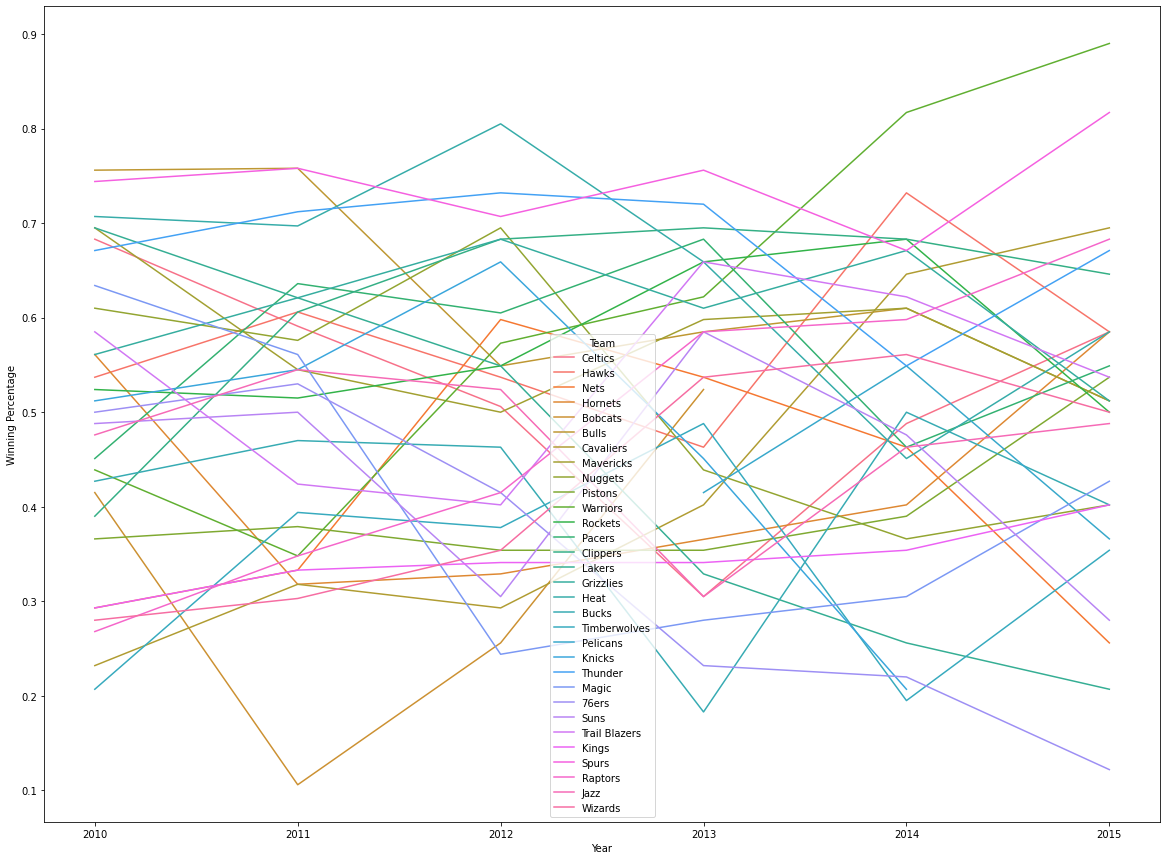

In [ ]:
#Plot Winning Percentage (winning vs losing record) over 2010-2015 seasons for all teams
#x-axis: Year
#y-axis: Winning Percentage
plt.figure(figsize=(20,15))
sns.lineplot(data=merged_data.drop(columns=['Relinquished']), x = "Year", y = "Winning Percentage", hue = "Team")

The graph above shows how the Winning Percentage (record) for each team changed over the six seasons we analyzed. It is typical for some teams' records to stay consistent over a duration because they have star players under contract or have consistent talent. Other teams may fluctuate due to losing players during free agency, injury, or trades. This graph is extremely hard to interpret so it only served as our intial data plot to get us started on our analysis.

In [ ]:
#Create Difference variable
#Difference = the current season Winning Percentage of a team minus that team's average Winning Percentage
avg = merged_data.groupby(['Team','Season']).sum().get('Winning Percentage')/merged_data.groupby(['Team','Season']).count().get('Winning Percentage')
avg1 = avg.groupby(['Team']).sum()/6
difference = merged_data.drop_duplicates().groupby(['Team','Season']).sum().get('Winning Percentage') - avg1
difference = pd.DataFrame(difference).reset_index().get('Winning Percentage')
merged_data = merged_data.assign(Difference = difference)
merged_data

,Season,Team,Acquired,Relinquished,Knee injuries,Ankle injuries,Foot injuries,Finger injuries,Back injuries,Hand injuries,Record,Winning Percentage,Year,Win,Loss,Difference
0,2015,Celtics,42.0,52.0,2.0,4.0,1.0,0.0,2.0,0.0,48-34,0.585,2015,48,34,0.1635
1,2014,Celtics,28.0,36.0,1.0,6.0,1.0,1.0,1.0,2.0,40-42,0.488,2014,40,42,0.1935
2,2013,Celtics,6.0,99.0,54.0,26.0,0.0,0.0,0.0,0.0,25-57,0.305,2013,25,57,0.0785
3,2012,Celtics,7.0,46.0,8.0,15.0,0.0,0.0,2.0,0.0,41-40,0.506,2012,41,40,-0.1045
4,2011,Celtics,28.0,68.0,10.0,10.0,2.0,0.0,3.0,0.0,39-27,0.591,2011,39,27,-0.1165
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
174,2014,Wizards,33.0,43.0,3.0,3.0,2.0,0.0,3.0,1.0,46-36,0.561,2014,46,36,-0.1195
175,2013,Wizards,13.0,53.0,18.0,2.0,7.0,3.0,4.0,0.0,44-38,0.537,2013,44,38,-0.0685
176,2012,Wizards,13.0,99.0,20.0,16.0,5.0,0.0,2.0,12.0,29-53,0.354,2012,29,53,0.1145
177,2011,Wizards,5.0,68.0,18.0,2.0,24.0,1.0,1.0,2.0,20-46,0.303,2011,20,46,0.1385


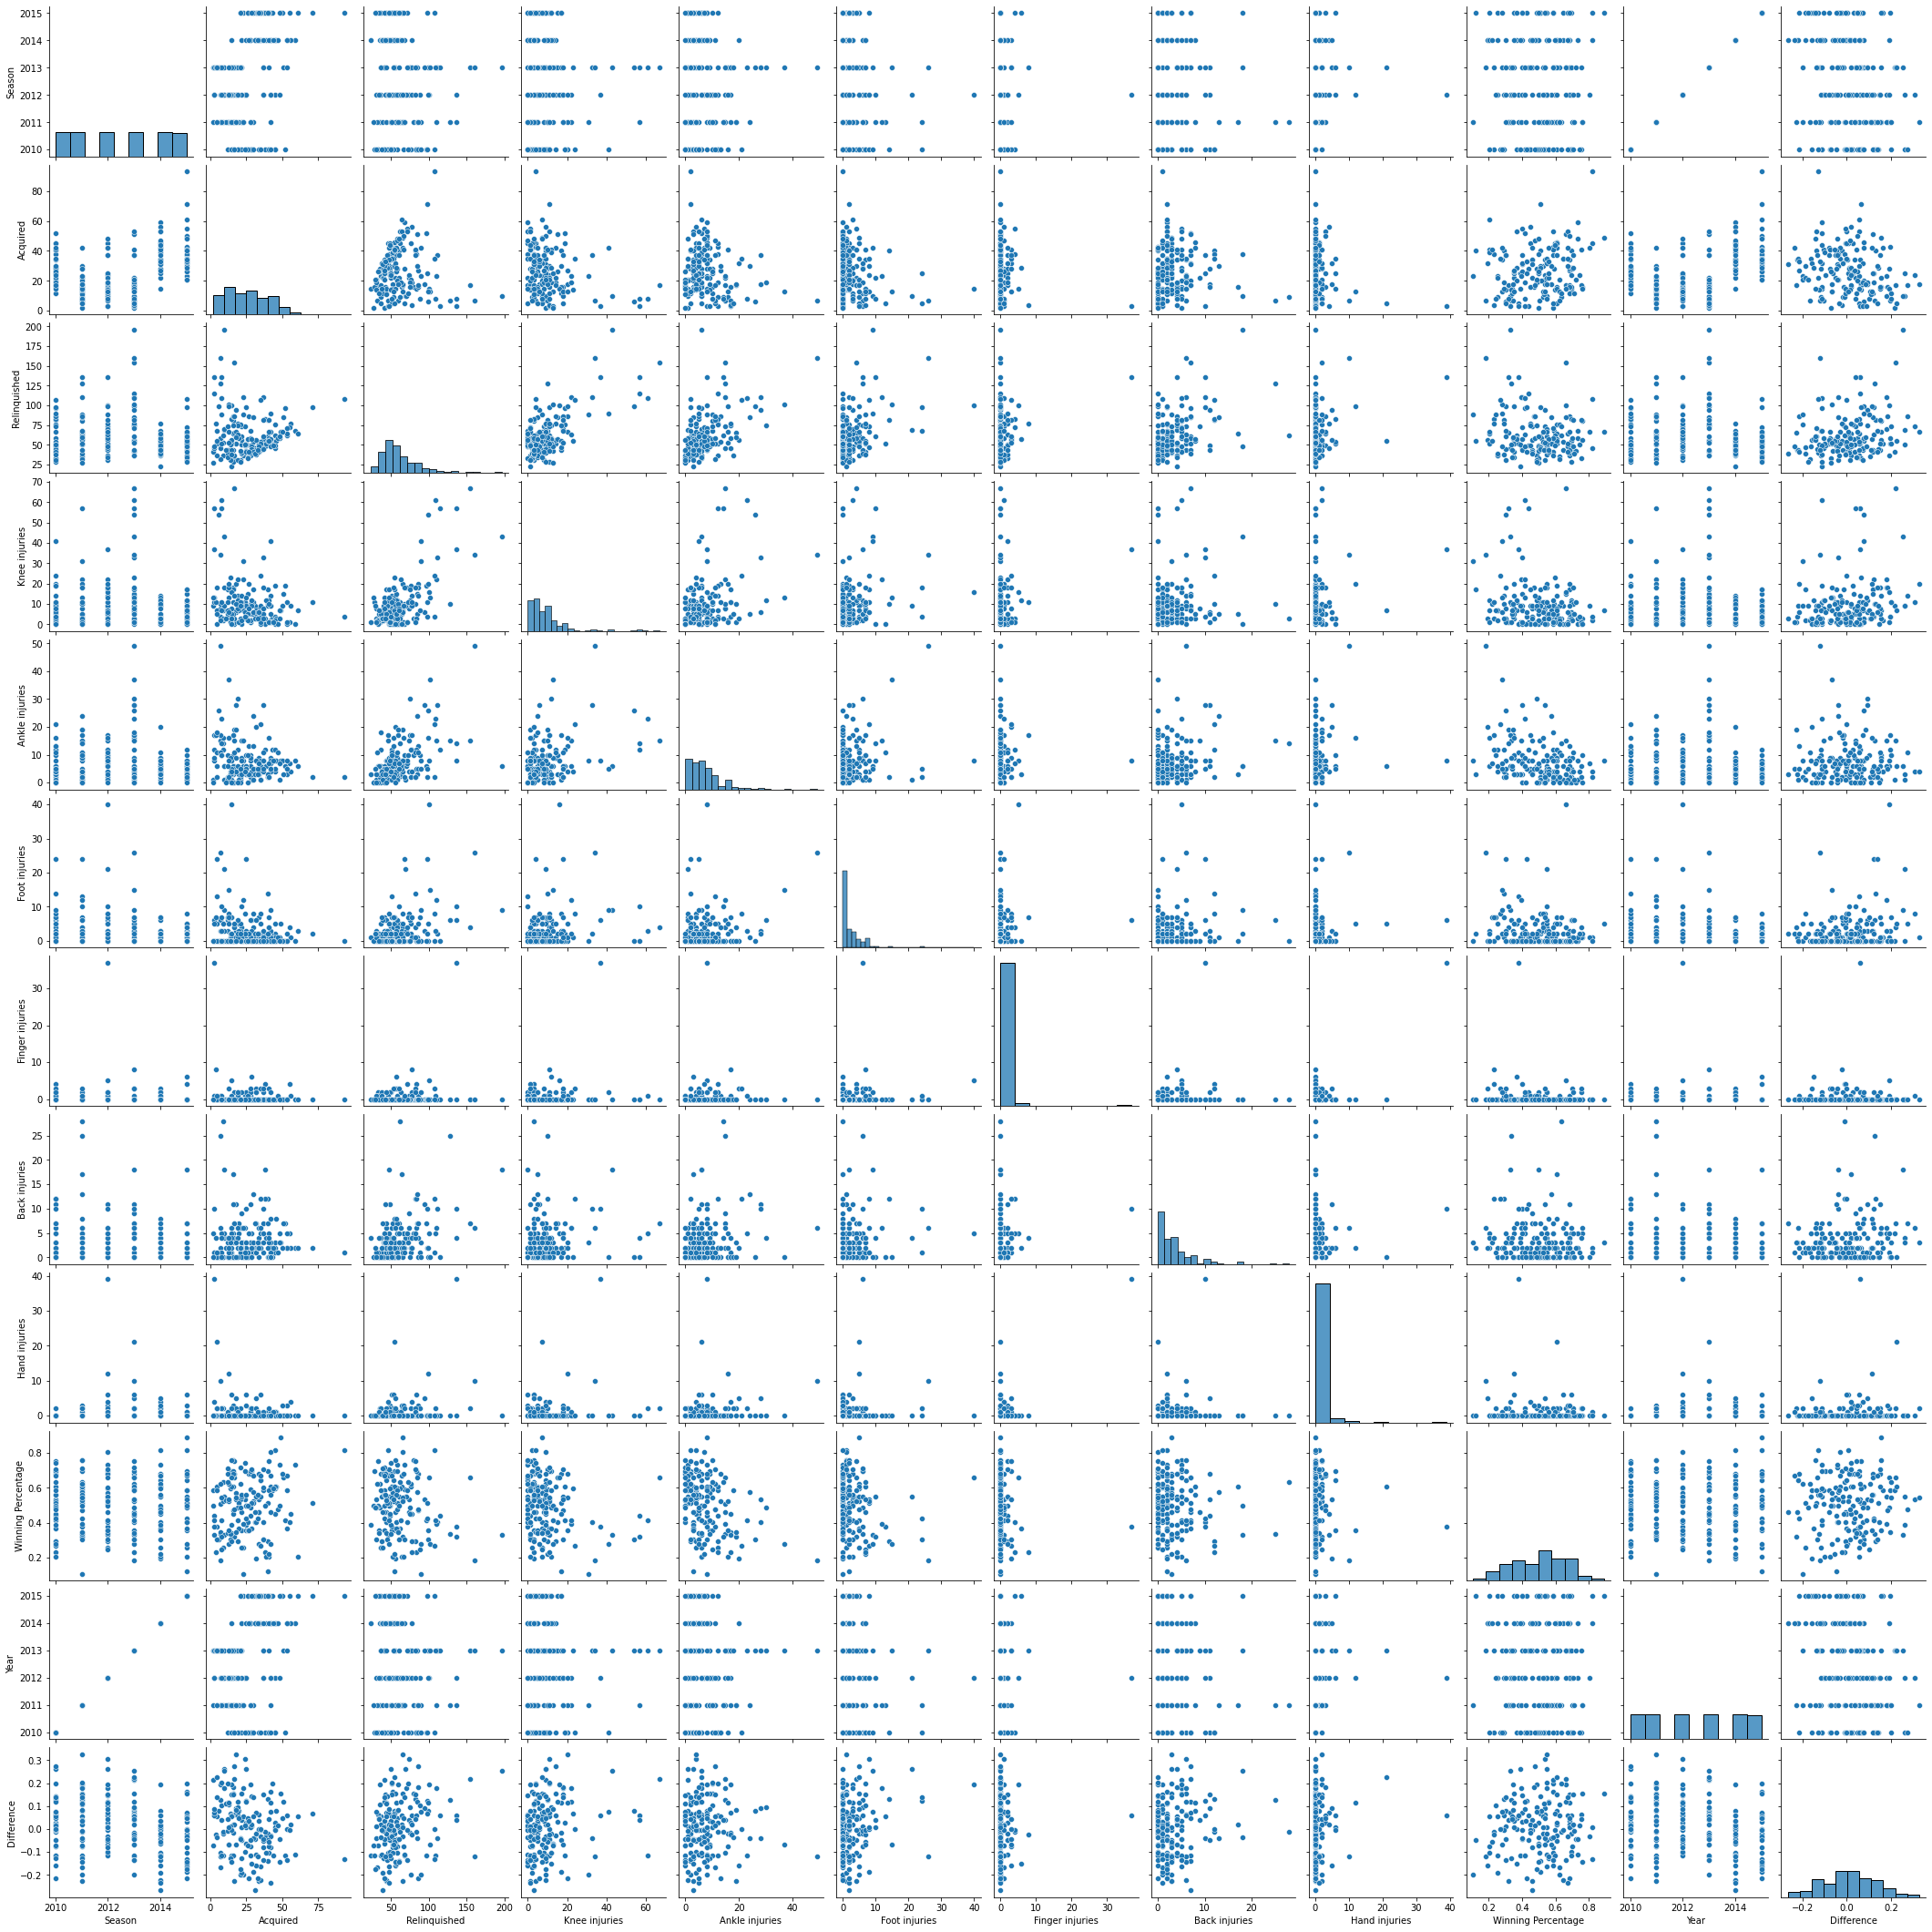

In [ ]:
#Pairplot of merged_data containing all variables
sns.pairplot(merged_data)
plt.show()

The pair plot above shows a combination of the variables from the merged_data dataframe. This served the purpose of giving us a general idea of what the vairables mapped on each other would look like.

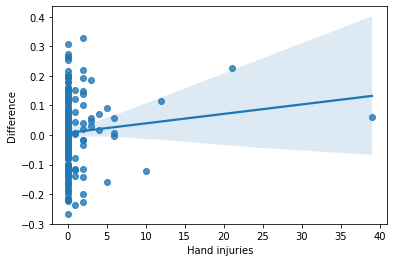

In [ ]:
#Exploratory plot: Difference vs. Hand Injury (One such example with Difference)
sns.regplot(data=merged_data, x="Hand injuries", y="Difference")

After creating the Difference variable, we plotted and tested what it would look like on a scatter plots. Originally, we did this to all of injury types on seperate scatter plots, but we didn't like what we observed. Many of these data points were clustered near the y-axis (at x = 0) and for the sake of our analysis, going forward we decided that it wasn't the best idea to use Difference as our y variable. We believed that the Difference variable was tragically flawed in that it didn't contain enough data points to be accurately compared. If we were to have conducted our analysis over many more seasons, we believe this would have been a more useful measurement.

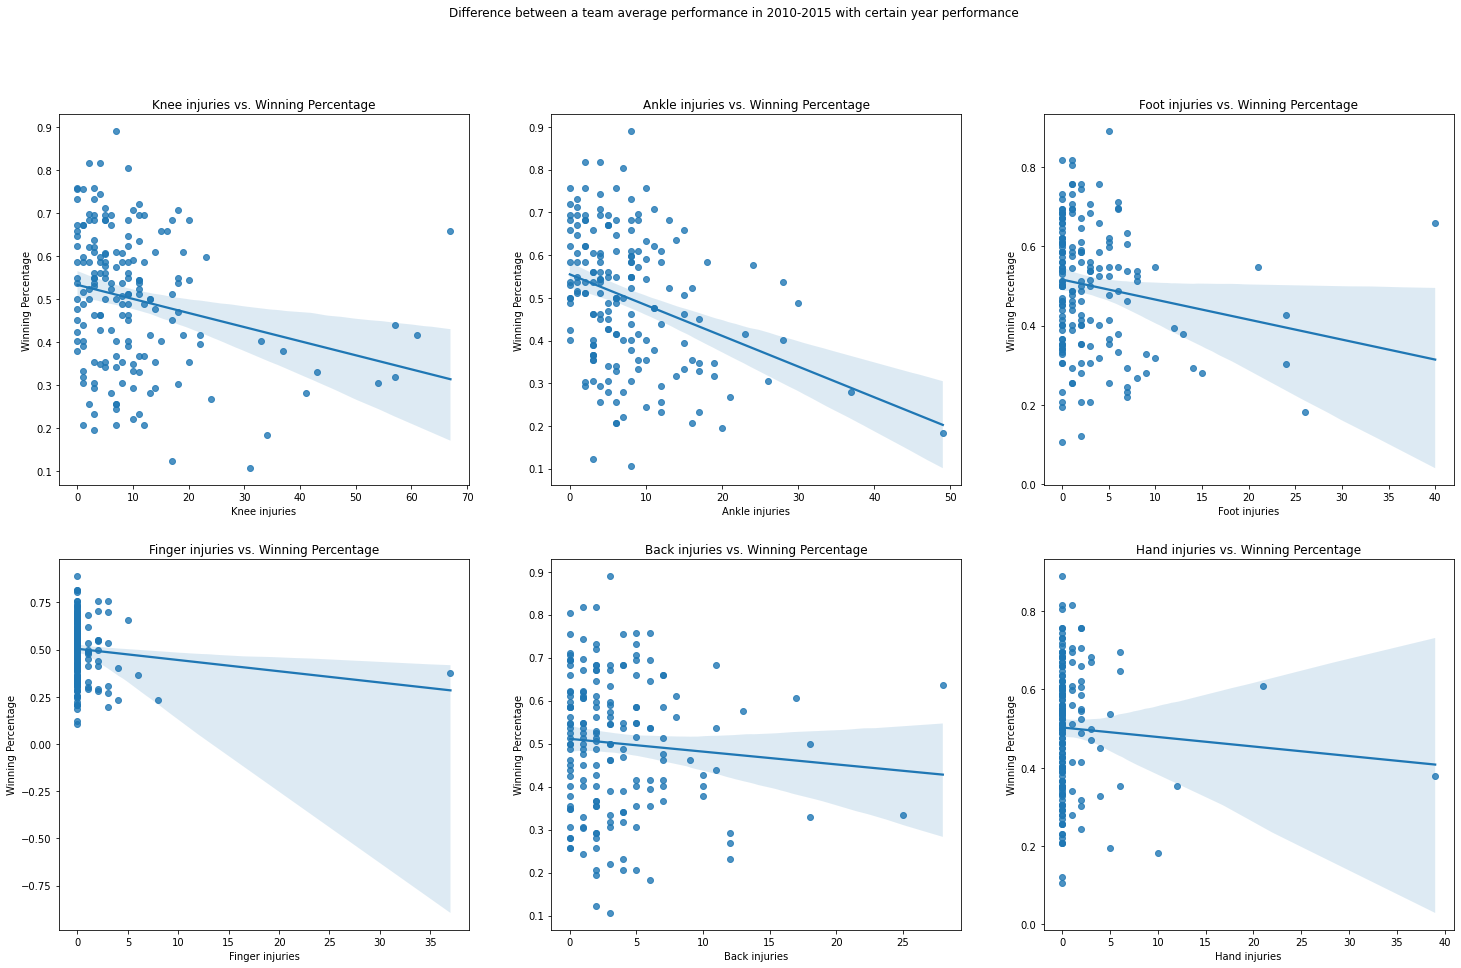

In [ ]:
#x-axis: Injury Type
#y-axis: Winning Percentage

fig, axes = plt.subplots(2, 3, figsize=(25, 15))
fig.suptitle('Difference between a team average performance in 2010-2015 with certain year performance')
ax=sns.regplot(ax=axes[0, 0],data=merged_data, x="Knee injuries", y="Winning Percentage")
ax.set_title("Knee injuries vs. Winning Percentage")
ax=sns.regplot(ax=axes[0, 1],data=merged_data, x="Ankle injuries", y="Winning Percentage")
ax.set_title("Ankle injuries vs. Winning Percentage")
ax=sns.regplot(ax=axes[0, 2],data=merged_data, x="Foot injuries", y="Winning Percentage")
ax.set_title("Foot injuries vs. Winning Percentage")
ax=sns.regplot(ax=axes[1, 0],data=merged_data, x="Finger injuries", y="Winning Percentage")
ax.set_title("Finger injuries vs. Winning Percentage")
ax=sns.regplot(ax=axes[1, 1],data=merged_data, x="Back injuries", y="Winning Percentage")
ax.set_title("Back injuries vs. Winning Percentage")
ax=sns.regplot(ax=axes[1, 2],data=merged_data, x="Hand injuries", y="Winning Percentage")
ax.set_title("Hand injuries vs. Winning Percentage")

f1 = plt.gcf()

These graphs are a continuation of what we attempted to do above. So, we plotted each type of injury versus the Winning Percentages. From an intial glance, we thought this was much better than plotting Difference vs. Injury types, however, it wasn't exactly what we were looking for. Across the different types of injuries, we observed regression lines that were weak negatives. As a result, we were happy to at least witness that there were somewhat negative relationships between the number of injuries and winning percentages.

But we were far from done. Many of these data points were still clustered around the y-axis and the regression lines did not fit the data well, so as a result, we believed that the outliers could have skewed the data. Another reason we thought these visualizations weren't the best was because we felt that we did not have enough data, thus potentially leading to confounds or spurious correlations.

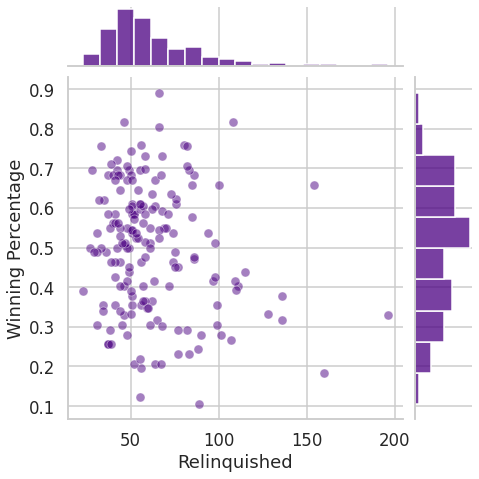

In [ ]:
#Exploratory plot: relationship between Winning Percentage and Relinquished (the overall number of injuries)
#x-axis: Relinquished
#y-axis: Winning Percentage

sns.set() 
sns.set_context('talk')
sns.set_style('whitegrid')

sns.jointplot(x = merged_data['Relinquished'], y = merged_data['Winning Percentage'], height = 7, color = 'indigo', alpha = 0.5)

According to this graph, we observed that the distribution of Winning Percentage was relatively normally distributed and the Relinquished variable distribution was rightly skewed. Also, this scatter plot possessed some outliers in the Relinquished direction of the graph.

In order to better understand if there is a linear relationship that exists, we drew a linear regression on the scatter plot.

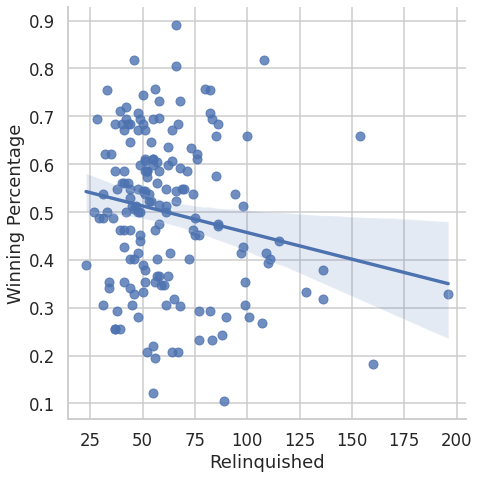

In [ ]:
sns.lmplot(x ='Relinquished', y ='Winning Percentage', data = merged_data, height = 7) 
plt.show()

The graph shows the linear relationship between the total number of injuries (Relinquished) against the Winning Percentage. This plot gave us a better perspective of the weak negative linear relationship between these two variables.

In [ ]:
#QUESTIONABLE????

#create group_merged_data, deleting all injuries and adding net injuries column

grouped_merged_data = merged_data.groupby('Team').sum()
grouped_merged_data['Net_Injuries'] = grouped_merged_data['Relinquished'] - grouped_merged_data['Acquired']
grouped_merged_data['Winning Percentage'] = grouped_merged_data['Winning Percentage'].apply(lambda x: x/6)

#convert Winning Percentagefrom ratio to actual percentage ~ (0-100)
winningPercentage = [x * 100 for x in grouped_merged_data['Winning Percentage']]
grouped_merged_data = grouped_merged_data.assign(winningPercentage=winningPercentage)
Acquired = grouped_merged_data['Acquired']
Relinquished = grouped_merged_data['Relinquished']
Net_Injuries = grouped_merged_data['Net_Injuries']

**Here we create an additional data frame called grouped_merged_data in which we:**
- Sum the variables by each team
- Create Net_Injuries variable (total number of injured players that didn't return to roster)
- Alter Winning Percentage to the average and change to a % from 0-100
- Also created some variables that will be used below

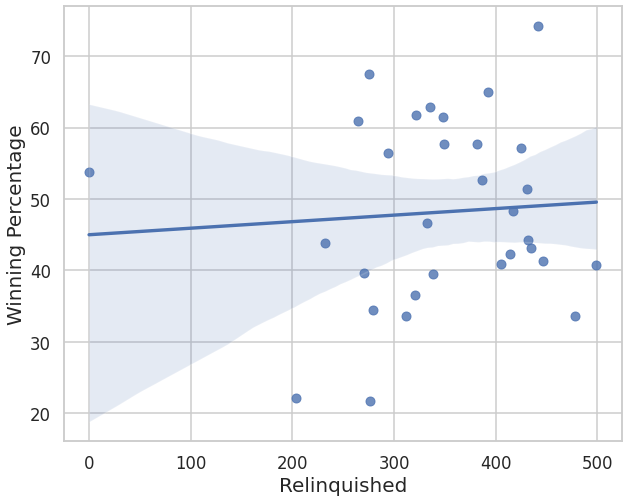

In [ ]:
#QUESTIONABLE????

#x-axis: Relinquished ~ (number of players that got injured per team and season)
#y-axis: Winning Percentage

plt.figure(figsize=(10,8))
plot = sns.regplot(x=Relinquished, y=winningPercentage)
temp = plot.set_ylabel("Winning Percentage", fontsize = 20)
temp = plot.set_xlabel("Relinquished", fontsize = 20)

The graph above shows the relationship between the total number of injuries (Relinquished) against their win percentage. There was a good balance between those who had a good season vs bad season with the same number of injuries.

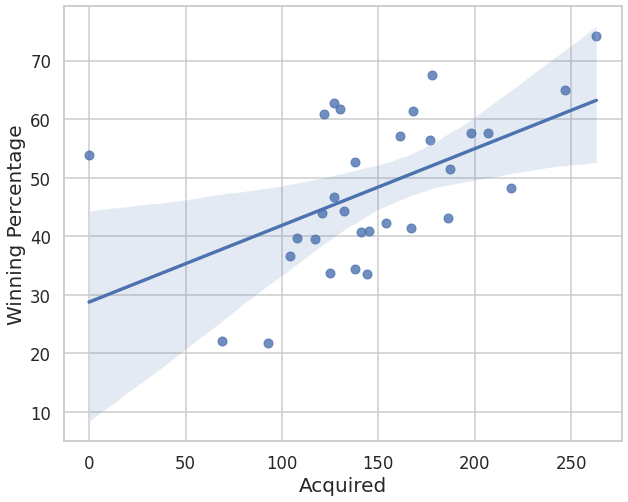

In [ ]:
#QUESTIONABLE????

#x-axis: Acquired ~ (number of players who got injured and returned to roster)
#y-axis: Winning Percentage

plt.figure(figsize=(10,8))
plot = sns.regplot(x=Acquired, y=winningPercentage)
temp = plot.set_ylabel("Winning Percentage", fontsize = 20)
temp = plot.set_xlabel("Acquired", fontsize = 20)

The graph above shows the relationship between the total number of players returning from injuries (Aquired) against their win percentage. Teams that got more players back from injury ended up having better records.

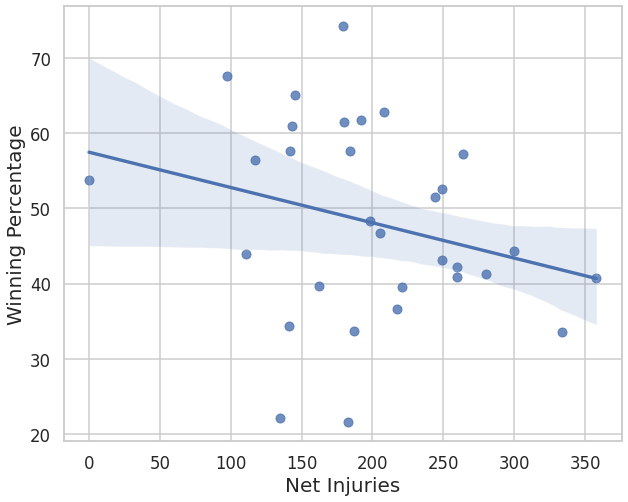

In [ ]:
#QUESTIONABLE????

#x-axis: Net_Injuries ~ (number of players that got injured and didn't return to roster that season)
#y-axis: Winning Percentage

plt.figure(figsize=(10,8))
plot = sns.regplot(x=Net_Injuries, y=winningPercentage)
temp = plot.set_ylabel("Winning Percentage", fontsize = 20)
temp = plot.set_xlabel("Net Injuries", fontsize = 20)
#plt.grid()

The graph above shows the relationship between the difference between reliquished and acquired against their win percentage. Teams that got less players back from injury (large x axis values) ended up having a worse record, but the best fit line is not very strong; there are many outliers and the error would be pretty high.

We then run OLS regression model individually on Relinquished and Acquired to see if there exists a significant relationship with the winning percentage.

In [ ]:
# Are the amount of injuries in a team correlated to the winning percentage over all years?
# The summary shows that it is not at all. 
outcome, predictors = patsy.dmatrices('winningPercentage ~ Relinquished')
mod = sm.OLS(outcome, predictors)
res = mod.fit() 
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:      winningPercentage   R-squared:                       0.005
Model:                            OLS   Adj. R-squared:                 -0.029
Method:                 Least Squares   F-statistic:                    0.1430
Date:                Fri, 03 Jun 2022   Prob (F-statistic):              0.708
Time:                        02:04:26   Log-Likelihood:                -122.69
No. Observations:                  31   AIC:                             249.4
Df Residuals:                      29   BIC:                             252.2
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept       45.0049      8.711      5.167   

In the above linear regression model, we only use one variable 'Relinquished' to predict the winning percentage. From the result, the coefficient is 0.0092, which is close to 0. The p-value is 0.708, which is bigger than the significant level of 0.05. Hence, we fail to reject null hypithesis and conclude that there is no significant relationship and Relinquished alone might not be a good model to predict the winning percentage.

In [ ]:
# Is the amount of players a team acquired correlated to the winning percentage over all years? 
# The summary shows that this is slightly more probably, but there is no significant correlation. 
outcome, predictors = patsy.dmatrices('winningPercentage ~ Acquired')
mod = sm.OLS(outcome, predictors)
res = mod.fit() 
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:      winningPercentage   R-squared:                       0.272
Model:                            OLS   Adj. R-squared:                  0.247
Method:                 Least Squares   F-statistic:                     10.83
Date:                Fri, 03 Jun 2022   Prob (F-statistic):            0.00263
Time:                        02:04:26   Log-Likelihood:                -117.84
No. Observations:                  31   AIC:                             239.7
Df Residuals:                      29   BIC:                             242.6
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     28.7555      6.235      4.612      0.0

In the above linear regression model, we only use one variable 'Acquired', which means the number of injured players returning to the game, to predict the winning percentage. From the result, the coefficient is 0.7865, which means for every returning player taht is recovered from injuries, the winning percentage increase by 0.7865. The p-value is 0.003, which is smaller than the significant level of 0.05. Hence, we reject null hypithesis and conclude that there is a significant relationship by convention and we should consider the variable Acquired in our model.

In [ ]:
knee = grouped_merged_data['Knee injuries']
ankle = grouped_merged_data['Ankle injuries']
foot = grouped_merged_data['Foot injuries']
finger = grouped_merged_data['Finger injuries']
back = grouped_merged_data['Back injuries']
hand = grouped_merged_data['Hand injuries']

outcome_1, predictors_1 = patsy.dmatrices('winningPercentage ~ Acquired + knee + ankle + foot + finger + back + hand')
mod_ = sm.OLS(outcome, predictors)
res = mod.fit() 
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:      winningPercentage   R-squared:                       0.272
Model:                            OLS   Adj. R-squared:                  0.247
Method:                 Least Squares   F-statistic:                     10.83
Date:                Fri, 03 Jun 2022   Prob (F-statistic):            0.00263
Time:                        02:04:26   Log-Likelihood:                -117.84
No. Observations:                  31   AIC:                             239.7
Df Residuals:                      29   BIC:                             242.6
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     28.7555      6.235      4.612      0.0

In the above model, we explore if the variables of different types of injuries and the Acquired together can form a linear model to predict the winning percentage.
Here, we see that we have very small p-values for the acquired. This suppports the claim that people that have more people returning from injuries have a better winning percentage. This does not support our hypothesis that the more injured players a team has, the team's winning percentage will be lower since the coefficient for the hand injuries variable is positive. Since for the regression statistics above (Relinquished vs performance), we see that we have a very high error and therefore our hypothesis is not supported.

[ 0.  2. 13.  1.  2.  2. 14. 22.  0.  7.  4.  0.  1.  2.  0.  2.  4.  5.
  0.  0.  2.  6.  5.  2.  8.  3.  2. 44.  0.  3. 15.]


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


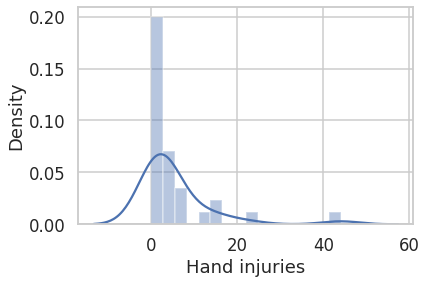

In [ ]:
#take a look at the distribution of hand injuries to see why the coefficient
#in the model is positive
sns.distplot(grouped_merged_data['Hand injuries'])
print(np.array(hand))

One of the possible reason this phenomenon occurs is that we do not have enough data points. The distribution of Hand Injuries is not normally distributed and contain outliers. As we can see from the above, one team has 44 hand injuries while most of the teams has less than 10. Hence, it is possible that the team with large amount of hand injuries are a strong team by coincidence and therefore has larger winning percentage, which might influence the result of the model. 

Since Acquired means how many players come back from injuries and Relinquished means the total amount of injuries of all types, we want to consider both of them simultaneously.
Due to the nature of the variables, we try to combine Acquired and Relinquished in our model.

Here we construct a multivariate linear regression model.

In [ ]:
outcome_1, predictors_1 = patsy.dmatrices('winningPercentage ~ Acquired+Relinquished')
mod_1 = sm.OLS(outcome_1, predictors_1)
res_1 = mod_1.fit() 
print(res_1.summary())

                            OLS Regression Results                            
Dep. Variable:      winningPercentage   R-squared:                       0.425
Model:                            OLS   Adj. R-squared:                  0.384
Method:                 Least Squares   F-statistic:                     10.34
Date:                Fri, 03 Jun 2022   Prob (F-statistic):           0.000433
Time:                        02:04:26   Log-Likelihood:                -114.19
No. Observations:                  31   AIC:                             234.4
Df Residuals:                      28   BIC:                             238.7
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept       39.3815      6.853      5.746   

The above linear regression model is consistent with what we assumed. As we assuemd, more acquired(players returning back to the game from injuries) would increase the winning percentage; while more relinquished(total number of players who got injured) would decrease the winning percentage. Both variables has a p-value smaller than the significnat level 0.05, hence we can reject the null hypothesis and conclude that there exists a significant relationshp between acquired+relinquished with winning percentage by convention.

Now we have two linear regression models that we want to consider:
- mod_1: that takes 'Acquired + knee + ankle + foot + finger + back + hand' as vaiables to predict the winning percentage and 
- mod_2: that only takes Acquired+Relinquished

We will evaluate the model by using Train?Test split to calculate the root of mean squred error. The model with smaller root of mean squred error will be considered as better prediciton for winning percentage.

In [ ]:
#calculate the RMSE from mod_1
X = grouped_merged_data[['Acquired','Finger injuries','Hand injuries',
                        'Knee injuries', 'Ankle injuries', 'Foot injuries','Back injuries']]
y = grouped_merged_data['winningPercentage']

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=10)

# Instantiate model
lm2 = LinearRegression()

# Fit Model
lm2.fit(X_train, y_train)

# Predict
y_pred = lm2.predict(X_test)

# RMSE
print(np.sqrt(metrics.mean_squared_error(y_test, y_pred)))


19.717804006030388


In [ ]:
#calculate the RMSE from mod_2
X = grouped_merged_data[['Acquired', 'Relinquished']]
y = grouped_merged_data['winningPercentage']

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=3)

# Instantiate model
lm2 = LinearRegression()

# Fit Model
lm2.fit(X_train, y_train)

# Predict
y_pred = lm2.predict(X_test)

# RMSE
print(np.sqrt(metrics.mean_squared_error(y_test, y_pred)))


10.070608484162536


In [ ]:
def predict_model_2(acquired, relinquished):
    predict_y = []
    for idx in range(len(acquired)):
        a = acquired[idx]
        r = relinquished[idx]
        predict_winning_percent = 39.3815 + 0.2229*a -0.0699*r
        predict_y.append(predict_winning_percent)
    return predict_y

a = list(grouped_merged_data['Acquired'])
r = list(grouped_merged_data['Relinquished'])
y_true = list(grouped_merged_data['winningPercentage'])
y_pred_2 = predict_model_2(a,r)

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


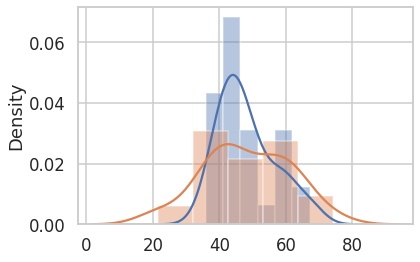

In [ ]:
sns.distplot(y_pred_2)
sns.distplot(y_true)

In [ ]:
theta, residuals, _, _ = np.linalg.lstsq(x, y, rcond=None)